## Post-processing script for 3DLeafSeg

#### Last edited by: M. Jenkins
#### Date:  03/16/2018

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage
from skimage import io
from skimage.transform import rescale
from skimage.morphology import remove_small_objects, skeletonize_3d
from skimage.measure import marching_cubes_lewiner, mesh_surface_area
from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage.filters import maximum_filter, median_filter, minimum_filter, percentile_filter

In [2]:
# Define filters for clipping off artefactual IAS protrusions due to dangling epidermis
def dbl_pct_filt(arr):
    out = percentile_filter(
        percentile_filter(
            arr, 
            size=30, 
            percentile=10),
        size=30,percentile=90)
    return(out)

def dbl_pct_filt2(arr):
    out = percentile_filter(
        percentile_filter(
            arr, 
            size=30, 
            percentile=5),
        size=30,percentile=95)
    return(out)

def min_max_filt(arr):
    out = minimum_filter(
        maximum_filter(arr,20),
        20)
    return out

def min_max_filt2(arr):
    out = minimum_filter(
        maximum_filter(arr,8),
        8)
    return out

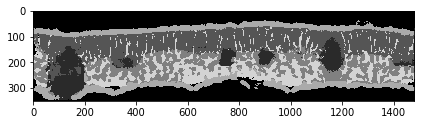

In [3]:
# Import full stack prediction from ML algorithm
filepath = '../../../ML_microCT/results/'
results_folder = 'test3_10'
img = io.imread(filepath+results_folder+'/fullstack_prediction.tif')
io.imshow(img[0,:,:])
io.show()

In [4]:
# define pixel values
epidermis = 170
spongy = 128
palisade = 85
ias = 212
bg = 0
vein = 42

In [5]:
# Remove 'dangling' epidermal pixels
epid = (img==epidermis)
epid_rmv_parts = np.array(epid, copy=True)
for i in range(0,epid_rmv_parts.shape[0]):
    epid_rmv_parts[i,:,:] = remove_small_objects(epid[i,:,:], min_size=1200)

# Write an array of just the removed particles
epid_parts = epid ^ epid_rmv_parts

# Replace the small connected epidermal particles (< 800 px^2) with BG value
img[epid_parts==1] = bg

# Do this again in another dimension
epid2 = (epid_rmv_parts==1)
epid_rmv_parts2 = np.array(epid2, copy=True)
for j in range(0,epid_rmv_parts.shape[1]):
    epid_rmv_parts2[:,j,:] = remove_small_objects(epid2[:,j,:], min_size=200)

# Write an array of just the removed particles, again
epid_parts2 = epid ^ epid_rmv_parts2

# Replace the small connected epidermal particles (< 800 px^2) with BG value
img[epid_parts2==1] = bg

# # Free up some memory
# del epid_rmv_parts
# del epid

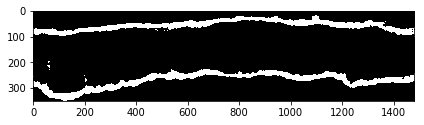

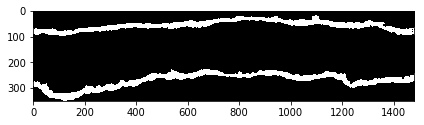

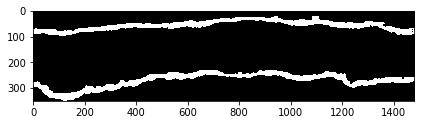

In [6]:
io.imshow(epid[120,:,:])
io.show()
io.imshow(epid2[120,:,:])
io.show()
io.imshow(epid_rmv_parts2[120,:,:])
io.show()

In [7]:
# Define 3D array of distances from lowest value img.shape[1] to highest value
a = range(0,img.shape[1])
b = np.tile(a,(img.shape[2],img.shape[0],1))
b = np.moveaxis(b,[0,1,2],[2,0,1])

/Users/mattjenkins1/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


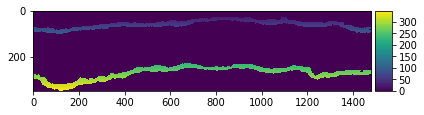

In [8]:
io.imshow(b[0,:,:]*epid_rmv_parts2[120,:,:])
io.show()

In [9]:
# Determine the lower edge of the spongy mesophyll
c = (img==spongy)
d = (b*c)
m_low = np.argmax(d, axis=1)
        
# Determine the lower edge of the vascular bundle
c = (img==vein)
d = (b*c)
v_low = np.argmax(d, axis=1)

# Determine the lower edge of the IAS
c = (img==ias)
d = (b*c)
ias_low = np.argmax(d, axis=1)

# Determine the lower edge of the epidermis
c = (img==epidermis)
d = (b*c)
e_low = np.argmax(d, axis=1)

e_low = np.maximum(e_low, m_low) # Changes lowest mesophyll pixel to epidermal class
e_low = np.maximum(e_low, ias_low) # Changes lowest IAS pixel to epidermal class
e_low = np.maximum(e_low, v_low) # Changes lowest vein pixel to epidermal class
epi_low = np.zeros(img.shape)
for z in range(0,epi_low.shape[0]):
    for x in range(0,epi_low.shape[2]):
        epi_low[z,e_low[z,x],x] = 1

        
b2 = np.flip(b,1)

# Determine the upper edge of palisade
c = (img==palisade)
d = ((b2)*c)
p_up = np.argmax(d, axis=1)

# Determine the upper edge of epidermis
c = (img==epidermis)
d = ((b2)*c)
e_up = np.argmax(d, axis=1)

e_up = np.maximum(e_up, p_up)

# e_up = np.apply_along_axis(dbl_pct_filt2, 0, arr = e_up)

epi_up = np.zeros(img.shape)
for z in range(0,epi_up.shape[0]):
    for x in range(0,epi_up.shape[2]):
        epi_up[z,e_up[z,x],x] = 1

# Combine the lower and upper edge of epidermis into a single numpy array
epi_both = epi_up + epi_low

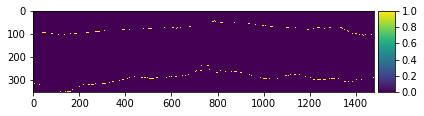

In [10]:
io.imshow(epi_both[65,:,:])
io.show()
# hold = (img==palisade)
# hold = (hold*b2)
# io.imshow(hold[65,:,:])
# io.show()

In [11]:
# Generate a binary stack with the pixels inside the new epidermis set equal to 1
epi_in = np.zeros(img.shape, dtype=np.uint16)
for y in range(0,epi_in.shape[2]):
    for z in range(0,epi_in.shape[0]):
        epi_in[z,e_up[z,y]:e_low[z,y],y] = 1
        
# Generate a binary stack with the pixels outside the new epidermis set equal to 1
epi_out = (epi_in==0)*1

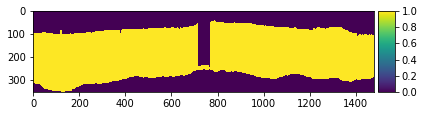

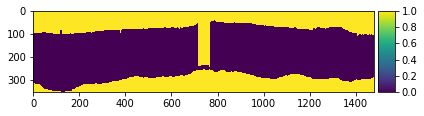

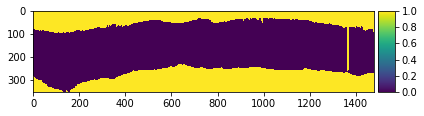

In [12]:
io.imshow(epi_in[65,:,:])
io.show()
io.imshow(epi_out[65,:,:])
io.show()
io.imshow(epi_out[239,:,:])
io.show()

In [13]:
# Set all background identified as IAS that lies outside epidermal boundaries as BG
# Set all IAS identified as BG that lies within epidermal boundaries as IAS
img2 = np.array(img, copy=True)
img2[(img2==ias)*(epi_out==1)] = bg
img2[(img2==bg)*(epi_in==1)] = ias

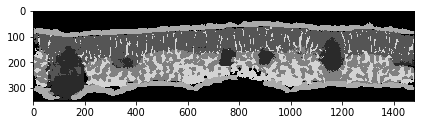

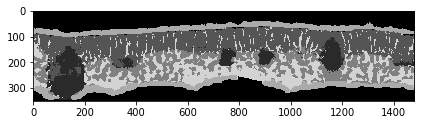

In [14]:
io.imshow(img[0,:,:])
io.show()
io.imshow(img2[0,:,:])
io.show()

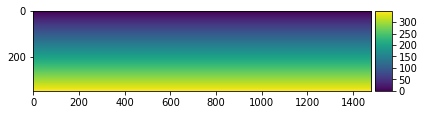

In [15]:
io.imshow(b[0,:,:])
io.show()

In [16]:
# Determine the lower edge of the spongy mesophyll
c = (img2==spongy)
d = (b*c)
s_low_2 = np.argmax(d, axis=1)

# Determine the lower edge of the IAS
c = (img2==ias)
d = (b*c)
ias_low_2 = np.argmax(d, axis=1)

# Determine the lower edge of the vascular bundle
c = (img2==vein)
d = (b*c)
v_low_2 = np.argmax(d, axis=1)

# Determine the lower edge of the epidermis
c = (img2==epidermis)
d = (b*c)
e_low_2 = np.argmax(d, axis=1)

e_low_2 = np.maximum(e_low_2, ias_low_2) # Changes lowest ias pixel to epidermis
e_low_2 = np.maximum(e_low_2, s_low_2) # Changes lowest spongy pixel to epidermis
e_low_2 = np.maximum(e_low_2, v_low_2) # Changes lowest vein pixel to epidermis

# e_low = np.apply_along_axis(dbl_pct_filt, 0, arr = e_low)
# e_low = np.apply_along_axis(min_max_filt, 0, arr = e_low)
# e_low = np.apply_along_axis(min_max_filt, 0, arr = e_low)

epi_low_2 = np.zeros(img2.shape)
for z in range(0,epi_low_2.shape[0]):
    for x in range(0,epi_low_2.shape[2]):
        epi_low_2[z,e_low_2[z,x],x] = 1

        
b2 = np.flip(b,1)

# Determine the upper edge of palisade
c = (img==palisade)
d = (b*c)
p_up = np.argmin(d, axis=1)

# Determine the upper edge of epidermis
c = (img==epidermis)
d = ((b2)*c)
e_up = np.argmax(d, axis=1)

e_up_2 = np.maximum(e_up, p_up)

e_up_2 = np.apply_along_axis(dbl_pct_filt, 0, arr = e_up_2)

epi_up_2 = np.zeros(img.shape)
for z in range(0,epi_up_2.shape[0]):
    for x in range(0,epi_up_2.shape[2]):
        epi_up_2[z,e_up_2[z,x],x] = 1

# Combine the lower and upper edge of epidermis into a single numpy array
epi_both_2 = epi_up_2 + epi_low_2

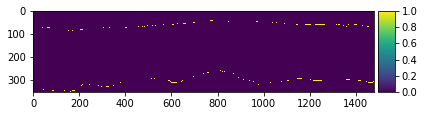

In [17]:
io.imshow(epi_both_2[0,:,:])
io.show()

In [18]:
# Generate a binary stack with the pixels inside the new epidermis set equal to 1
epi_in_2 = np.zeros(img.shape, dtype=np.uint16)
for y in range(0,epi_in_2.shape[2]):
    for z in range(0,epi_in_2.shape[0]):
        epi_in_2[z,e_up_2[z,y]:e_low_2[z,y],y] = 1
        
# Generate a binary stack with the pixels outside the new epidermis set equal to 1
epi_out_2 = (epi_in_2==0)*1

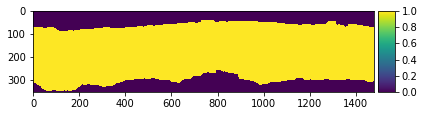

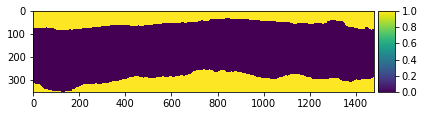

In [19]:
io.imshow(epi_in_2[0,:,:])
io.show()
io.imshow(epi_out_2[65,:,:])
io.show()

In [20]:
# Set all background identified as IAS that lies outside epidermal boundaries as BG
# Set all IAS identified as BG that lies within epidermal boundaries as IAS
img3 = np.array(img2, copy=True)
img3[(img3==ias)*(epi_out_2==1)] = bg
img3[(img3==bg)*(epi_in_2==1)] = ias

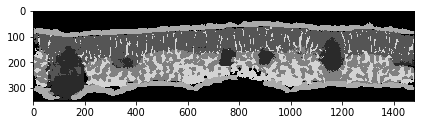

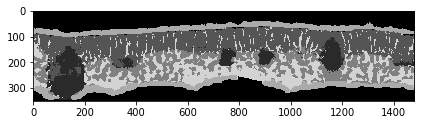

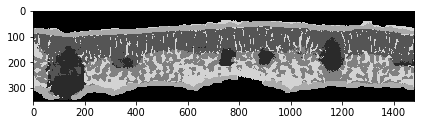

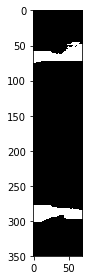

In [21]:
slice = 0
io.imshow(img[slice,:,:])
io.show()
io.imshow(img2[slice,:,:])
io.show()
io.imshow(img3[slice,:,:])
io.show()
io.imshow(c[slice,:,1240:1310])
io.show()

In [22]:
vein_trace = (img3==vein)
palisade_trace = (img3==palisade)
palisade_trace_invert = (palisade_trace==0)*1
spongy_trace = (img==spongy)
spongy_trace_invert = (spongy_trace==0)*1

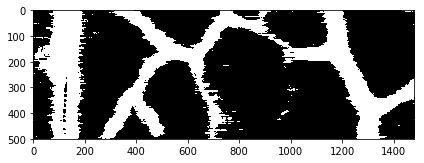

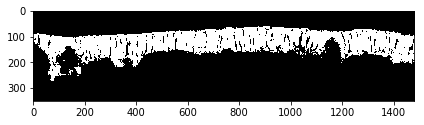

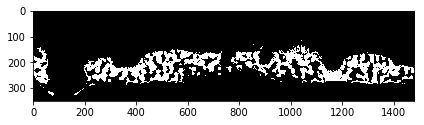

In [23]:
io.imshow(vein_trace[:,190,:])
io.show()
io.imshow(palisade_trace[0,:,:])
io.show()
io.imshow(spongy_trace[0,:,:])
io.show()

In [48]:
# Remove 'dangling' vein pixels
vein_rmv_parts = np.array(vein_trace, copy=True)
for i in range(0,vein_rmv_parts.shape[0]):
    vein_rmv_parts[i,:,:] = remove_small_objects(vein_trace[i,:,:], min_size=600)

# Write an array of just the removed particles
vein_parts = vein_trace ^ vein_rmv_parts 

# Replace small vein parts with spongy mesophyll
img3[vein_parts==1] = spongy

# # Free up some memory
# del epid_rmv_parts
# del epid

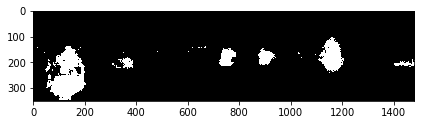

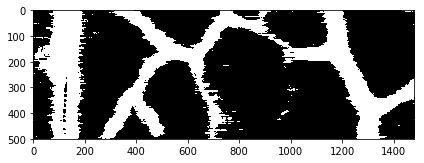

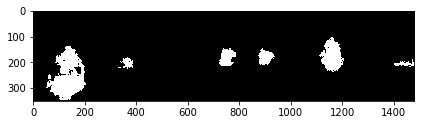

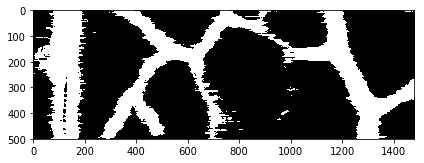

In [49]:
io.imshow(vein_trace[0,:,:])
io.show()
io.imshow(vein_trace[:,190,:])
io.show()
io.imshow(vein_rmv_parts[0,:,:])
io.show()
io.imshow(vein_rmv_parts[:,190,:])
io.show()
# io.imshow(vein_rmv_parts2[0,:,:])
# io.show()
# io.imshow(vein_rmv_parts2[:,190,:])
# io.show()

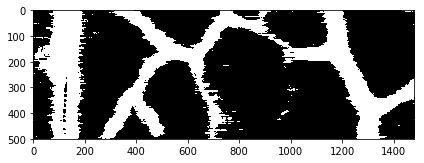

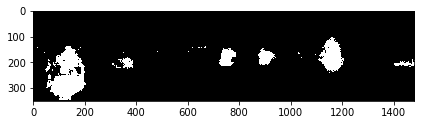

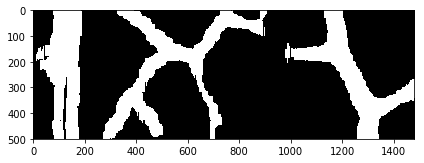

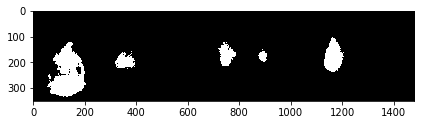

In [50]:
vein_trace_pct = np.apply_along_axis(dbl_pct_filt, 0, arr = vein_rmv_parts)
# vein_trace_pct2 = np.apply_along_axis(dbl_pct_filt2, 0, arr = vein_trace)
# vein_trace_minmax = np.apply_along_axis(min_max_filt, 0, arr = vein_rmv_parts)
# vein_trace_minmax2 = np.apply_along_axis(min_max_filt2, 0, arr = vein_trace)
# vein_trace_dblminmax = np.apply_along_axis(min_max_filt2, 0, arr = vein_trace_minmax)
# vein_trace_pctminmax = np.apply_along_axis(dbl_pct_filt, 0, arr = vein_trace_minmax)
# vein_trace_pctminmax2 = np.apply_along_axis(dbl_pct_filt2, 0, arr = vein_trace_minmax)
number = 190
io.imshow(vein_trace[:,number,:])
io.show()
io.imshow(vein_trace[0,:,:])
io.show()
io.imshow(vein_trace_pct[:,number,:])
io.show()
io.imshow(vein_trace_pct[0,:,:])
io.show()
# io.imshow(vein_trace_pct2[:,number,:])
# io.show()
# io.imshow(vein_trace_minmax[:,number,:])
# io.show()
# io.imshow(vein_trace_minmax[0,:,:])
# io.show()
# io.imshow(vein_trace_minmax2[:,number,:])
# io.show()
# io.imshow(vein_trace_dblminmax[:,number,:])
# io.show()
# io.imshow(vein_trace_pctminmax[:,number,:])
# io.show()
# io.imshow(vein_trace_pctminmax2[:,number,:])
# io.show()

In [51]:
# invert_vt_minmax = np.invert(vein_trace_minmax)

invert_vt_pct = np.invert(vein_trace_pct)

In [52]:
#Set all mesophyll identified as vein that lies oustide vein boundary as spongy mesophyll
img4 = np.array(img3, copy=True)
img4[(img4==vein)*(invert_vt_pct==1)] = spongy
#Set all vein identified as palisade or spongy that lies inside vein boundary as vein
img4[((img4==palisade)*(vein_trace_pct==1))] = vein
img4[(img4==spongy)*(vein_trace_pct==1)] = vein

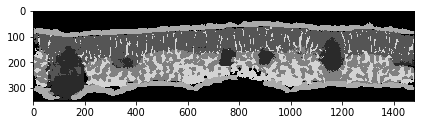

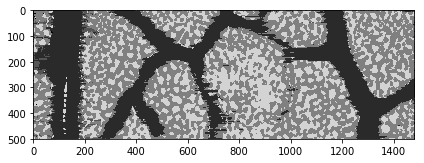

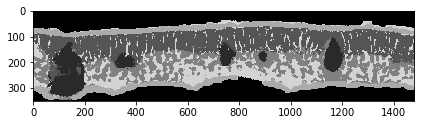

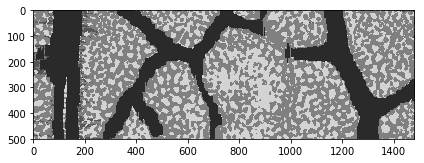

In [53]:
slice1 = 0
slice2 = 190
io.imshow(img[slice1,:,:])
io.show()
io.imshow(img[:,slice2,:])
io.show()
# io.imshow(img2[slice,:,:])
# io.show()
# io.imshow(img3[slice,:,:])
# io.show()
io.imshow(img4[slice1,:,:])
io.show()
io.imshow(img4[:,slice2,:])
io.show()

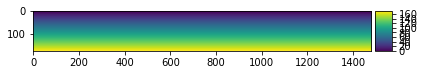

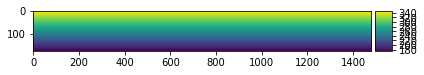

In [131]:
# Define 3D array of distances from lower value of img.shape[1] to median value
rangeA = range(0,img4.shape[1]/2)
tileA = np.tile(rangeA,(img4.shape[2],img4.shape[0],1))
tileA = np.moveaxis(tileA,[0,1,2],[2,0,1])
io.imshow(tileA[0,:,:])
io.show()
# Define 3D array of distances from upper value of image.shape[1] to median value
rangeB = range(img4.shape[1]/2,img4.shape[1])
tileB = np.tile(rangeB,(img4.shape[2],img4.shape[0],1))
tileB = np.moveaxis(tileB,[0,1,2],[2,0,1])
tileB = np.flip(tileB,1)
io.imshow(tileB[0,:,:])
io.show()

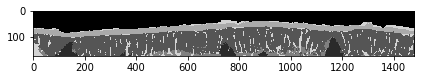

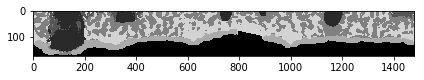

In [132]:
hold = img4.shape[1]/2
img4conc1 = np.array(img4[:,0:hold,:], copy = True) 
img4conc2 = np.array(img4[:,hold:img4.shape[1],:], copy = True)
io.imshow(img4conc1[0,:,:])
io.show()
io.imshow(img4conc2[0,:,:])
io.show()

In [133]:
# Determine the inner edge of the upper epidermis
c = (img4conc1==epidermis)
d = (tileA*c)
e_low_in = np.argmax(d, axis=1)

# e_low_in = np.maximum(e_low_in, p_low_in) # Checks if mesophyll cells are below lower epidermis
#                                  # Changes mesophyll pixel to epidermal class
# e_low_in = np.maximum(e_low_in, ias_low_in) # Similar to above, but with ias

epi_low_in = np.zeros(img.shape)
for z in range(0,epi_low_in.shape[0]):
    for x in range(0,epi_low_in.shape[2]):
        epi_low_in[z,e_low_in[z,x],x] = 1

# Determine the lower edge of the spongy mesophyll
c = (img4conc2==spongy)
d = (tileA*c)
m_up_in = np.argmax(d, axis=1)
# Determins the lower edge of vein
c = (img4conc2==vein)
d = (tileA*c)
v_up_in = np.argmax(d,axis=1)
# Determine the lower edge of ias
c = (img4conc2==ias)
d = (tileA*c)
ias_up_in = np.argmax(d, axis=1)        

#Determine the inner edge of the lower epidermis
c = (img4conc2==epidermis)
d = (tileB*c)
e_up_in = np.argmax(d, axis=1)

e_up_in = np.maximum(e_up_in, m_up_in) # Checks if mesophyll cells are below lower epidermis
                                 # Changes lowest mesophyll pixel to epidermal class
e_up_in = np.maximum(e_up_in, ias_up_in) # Similar to above, but with ias
e_up_in = np.maximum(e_up_in, v_up_in)
epi_up_in = np.zeros(img.shape)
hold = img4.shape[1]/2
for z in range(0,epi_up_in.shape[0]):
    for x in range(0,epi_up_in.shape[2]):
        epi_up_in[z,e_up_in[z,x]+hold,x] = 1
#add lower and upper halves
epi_inner_trace = np.add(epi_low_in,epi_up_in)

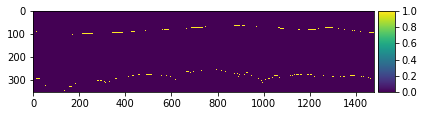

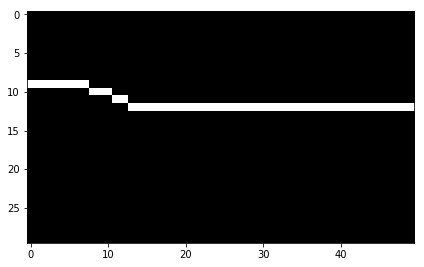

In [134]:
io.imshow(epi_inner_trace[0,:,:])
io.show()
io.imshow(epi_inner_trace[0,90:120,100:150])
io.show()

In [135]:
# # Generate a binary stack with the pixels inside the new epidermis set equal to 1
# epi_inner = np.zeros(img4.shape)
# for y in range(0,epi_inner.shape[2]):
#     for z in range(0,epi_inner.shape[0]):
#         epi_inner[z,hold-e_up_in[z,y]:e_low_in[z,y]+hold,y] = 1
        
# Generate a binary stack with the pixels inside the inner epidermis trace set equal to 1
epi_inner_up = np.zeros(img4conc1.shape, dtype=np.uint16)
for y in range(0,epi_inner_up.shape[2]):
    for z in range(0,epi_inner_up.shape[0]):
        epi_inner_up[z,:e_up_in[z,y],y] = 1

epi_inner_down = np.zeros(img4conc2.shape, dtype=np.uint16)
for y in range(0,epi_inner_down.shape[2]):
    for z in range(0,epi_inner_down.shape[0]):
        epi_inner_down[z,:e_low_in[z,y],y] = 1
epi_inner_down = (epi_inner_down==0)*1
        
# # Generate a binary stack with the pixels outside the new epidermis set equal to 1
# epi_inner_invert = (epi_inner==0)*1

#add lower and upper halves
epi_inner_fill = np.concatenate((epi_inner_down,epi_inner_up), axis = 1)
epi_inner_fill_invert = (epi_inner_fill==0)*1

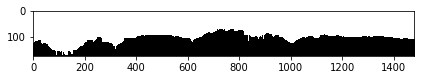

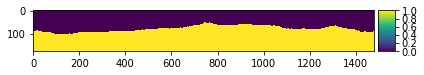

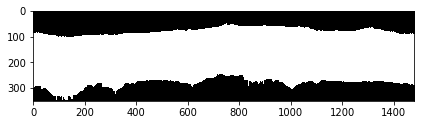

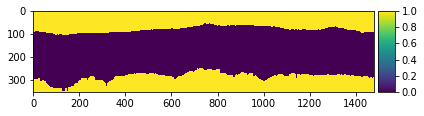

In [136]:
io.imshow(epi_inner_up[10,:,:])
io.show()
io.imshow(epi_inner_down[10,:,:])
io.show()
io.imshow(epi_inner_fill[10,:,:])
io.show()
io.imshow(epi_inner_fill_invert[10,:,:])
io.show()

In [137]:
# Set all background identified as IAS that lies outside epidermal boundaries as BG
# Set all IAS identified as BG that lies within epidermal boundaries as IAS
img5 = np.array(img4, copy=True)
img5[(img4==ias)*(epi_inner_fill_invert==1)] = bg
img5[(img4==bg)*(epi_inner_fill==1)] = ias

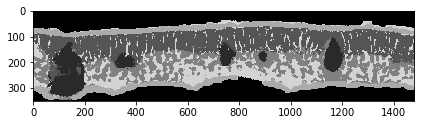

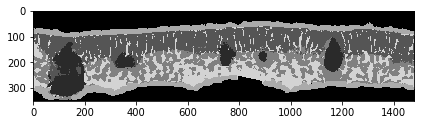

In [138]:
io.imshow(img4[0,:,:])
io.show()
io.imshow(img5[0,:,:])
io.show()

In [ ]:
# Save post-processed predicted stack
io.imsave(filepath+results_folder+'/prediction_postprocess6.tif', img5)

In [ ]:
io.imshow(img[0,100:400,700:1000])
io.show()
io.imshow(img2[0,100:400,700:1000])
io.show()
io.imshow(img3[0,100:400,700:1000])
io.show()
io.imshow(img4[0,100:400,700:1000])
io.show()